In [1]:
import os
os.environ["OPENBLAS_VERBOSE"] = "0"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
# importa os pacotes necessarios
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

2025-06-21 12:44:38.862634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750509879.324627      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750509879.438072      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


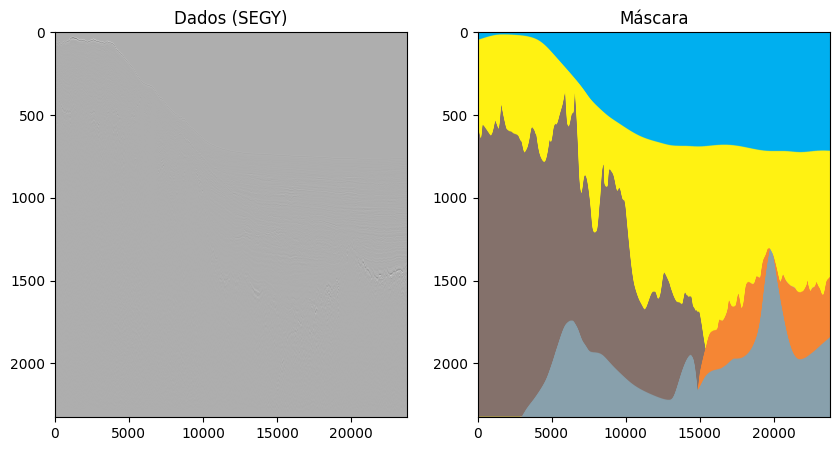

Dimensão do dado original: (2326, 23777)
Dimensão da máscara: (2326, 23777, 3)


In [3]:
# verificando ambas imagens (arquivo npy do dado e a mascara construida)
import matplotlib.pyplot as plt

image_data = np.load('/kaggle/input/aprendizadomaquina/BB08RE11-210-PRCMIG.npy')
imageMascara = '/kaggle/input/aprendizadomaquina/Mascara_210_4 (1).png'
# Ler a imagem com três canais
imgMascara = cv2.imread(imageMascara)
imgMascara = cv2.cvtColor(imgMascara, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_data, cmap='gray', aspect='auto')
plt.title('Dados (SEGY)')

plt.subplot(1, 2, 2)
plt.imshow(imgMascara, aspect='auto')  # Mantendo a cor
plt.title('Máscara')

plt.show()

# Certificando que ambos estão na msm dimensão
print("Dimensão do dado original:", image_data.shape)
print("Dimensão da máscara:", imgMascara.shape)

In [4]:
from scipy.ndimage import uniform_filter, gaussian_filter, sobel
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte
import numpy as np

# Garantir imagem 2D (caso tenha um canal extra)
if image_data.ndim > 2:
    image = image_data[:, :, 0]
else:
    image = image_data

# Atributo 1: Amplitude (valor absoluto)
attr_amplitude = np.abs(image)

# Atributo 2: Variância local
local_mean = uniform_filter(image, size=7)
local_sqr_mean = uniform_filter(image**2, size=7)
attr_variance = local_sqr_mean - local_mean**2

# Atributo 3: Entropia local
image_ubyte = img_as_ubyte((image - image.min()) / (image.max() - image.min()))
attr_entropy = entropy(image_ubyte, disk(5))

# Atributo 4: Gradiente (sobel)
attr_gradient = np.hypot(sobel(image, axis=0), sobel(image, axis=1))

# Atributo 5: Média local (gaussiano)
attr_gauss = gaussian_filter(image, sigma=3)

# Empilhar todos os atributos (como canais)
attr_stack = np.stack([
    attr_amplitude,
    attr_variance,
    attr_entropy,
    attr_gradient,
    attr_gauss
], axis=-1)

# Verificar dimensões
print("Dimensões da imagem com atributos:", attr_stack.shape)

Dimensões da imagem com atributos: (2326, 23777, 5)


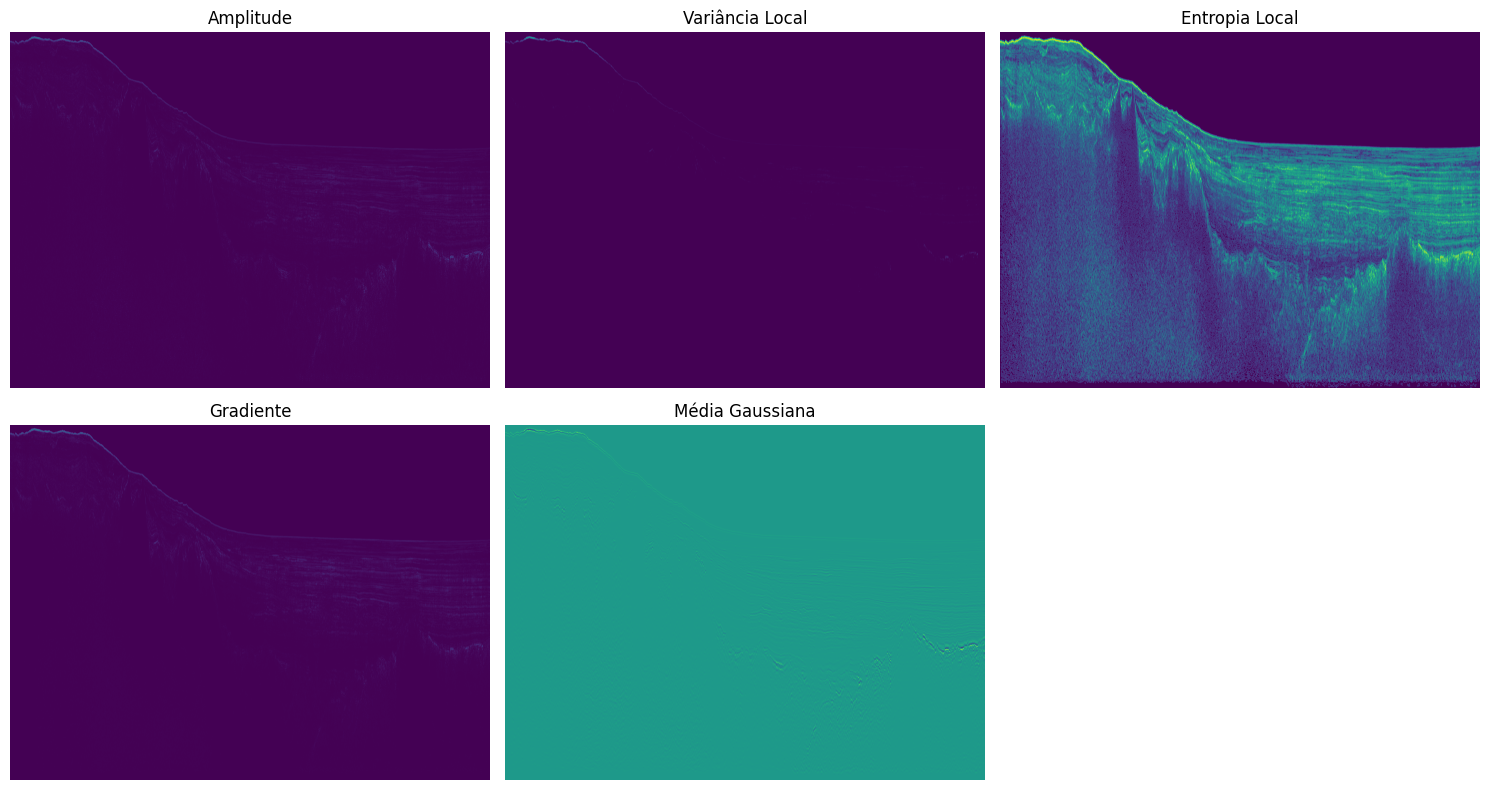

In [5]:
# Lista com os nomes dos atributos e os arrays correspondentes
attr_names = ['Amplitude', 'Variância Local', 'Entropia Local', 'Gradiente', 'Média Gaussiana']

plt.figure(figsize=(15, 8))

for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(attr_stack[:, :, i], cmap='viridis', aspect='auto')
    plt.title(attr_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Foi usado ferramenta para verificar o RGB dos pixel das classes
color_to_class = {
    (0, 175, 239): 'agua',  # Azul
    (255, 242, 18): 'bacia sedimentar',  # Amarelo
    (132, 113, 107): 'crosta continental',  # Marrom
    (245, 134, 52): 'crosta oceanica',  # Laranja
    (136, 160, 172): 'manto'  # Cinza
}

In [7]:
# Função para encontrar a classe predominante em um patch
def get_dominant_class(patch, color_to_class):
    # Reformatar o patch para (N, 3) para facilitar a contagem de cores
    reshaped_patch = patch.reshape(-1, 3)
    unique_colors, counts = np.unique(reshaped_patch, axis=0, return_counts=True)

    # Encontrar a cor predominante
    dominant_color = unique_colors[np.argmax(counts)]

    # Mapear para a classe correspondente
    return color_to_class.get(tuple(dominant_color), 'unknown')  # Retorna 'unknown' se a cor não estiver mapeada

In [8]:
# Codigo para dividir em patches, verificar a maior quantidade de pixel presente na mascara de acordo com a informação acima e atribuir o rotulo correspondente
# # Caminho do arquivo .npy
# image_npy_path = '/content/drive/MyDrive/newProjetoMeco/BB08RE11-210-PRCMIG/BB08RE11-210-PRCMIG.npy'

# # Carregar a imagem .npy
# image_data = np.load(image_npy_path)

height, width = attr_stack.shape[:2]
patch_size = (64, 64)

# Ajustar para múltiplos de 64
new_height = (height // patch_size[0]) * patch_size[0]
new_width = (width // patch_size[1]) * patch_size[1]

# Recortar atributos e máscara para tamanhos ajustados
adjusted_attr_stack = attr_stack[:new_height, :new_width, :]
adjusted_mask = imgMascara[:new_height, :new_width, :]

# Dividir os atributos e a máscara em patches
attr_patches = []
mask_patches = []

for i in range(0, new_height, patch_size[0]):
    for j in range(0, new_width, patch_size[1]):
        # Extrair patches dos atributos (com 5 canais) e da máscara
        attr_patch = adjusted_attr_stack[i:i+patch_size[0], j:j+patch_size[1], :]  # shape: (64, 64, 5)
        mask_patch = adjusted_mask[i:i+patch_size[0], j:j+patch_size[1], :]        # shape: (64, 64, 3)

        attr_patches.append(attr_patch)
        mask_patches.append(mask_patch)

# Garantir que os números de patches são iguais
assert len(attr_patches) == len(mask_patches), "Número de patches de atributos e máscara não corresponde!"

# Determinar os rótulos com base na máscara
patch_labels = [get_dominant_class(patch, color_to_class) for patch in mask_patches]

# Verificar
print("Total de patches (atributos):", len(attr_patches))
print("Total de patches (máscara):", len(mask_patches))
print("Classes encontradas:", set(patch_labels))

Total de patches (atributos): 13356
Total de patches (máscara): 13356
Classes encontradas: {'crosta continental', 'manto', 'crosta oceanica', 'agua', 'bacia sedimentar'}


In [9]:
# verificando a quantidade presente em cada classe
from collections import Counter
class_counts = Counter(patch_labels)
for class_name, count in class_counts.items():
    print(f"Classe '{class_name}': {count} patches")

Classe 'agua': 2813 patches
Classe 'bacia sedimentar': 4231 patches
Classe 'crosta continental': 4016 patches
Classe 'crosta oceanica': 627 patches
Classe 'manto': 1669 patches


## Extração de atributos

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 0. Carregamento e reshape dos dados
attr_patches = np.array(attr_patches) 
n_samples = attr_patches.shape[0]
X = attr_patches.reshape(n_samples, -1)  # shape: (n_amostras, 64*64*5)

# 1. Aplicação do PCA
n_components = 100  # número de componentes principais que deseja manter
pca = PCA(n_components=n_components, random_state=42)
BaseReduzida3 = pca.fit_transform(X)  # shape: (n_amostras, n_components)

print(f'BaseReduzida3 criada com shape: {BaseReduzida3.shape}')
print(f'Variância explicada acumulada: {np.sum(pca.explained_variance_ratio_):.4f}')

BaseReduzida3 criada com shape: (13356, 100)
Variância explicada acumulada: 0.9565


In [11]:
X_balanced = np.array(BaseReduzida3)
y_balanced = np.array([list(color_to_class.values()).index(label) for label in patch_labels])

X_flat = X_balanced

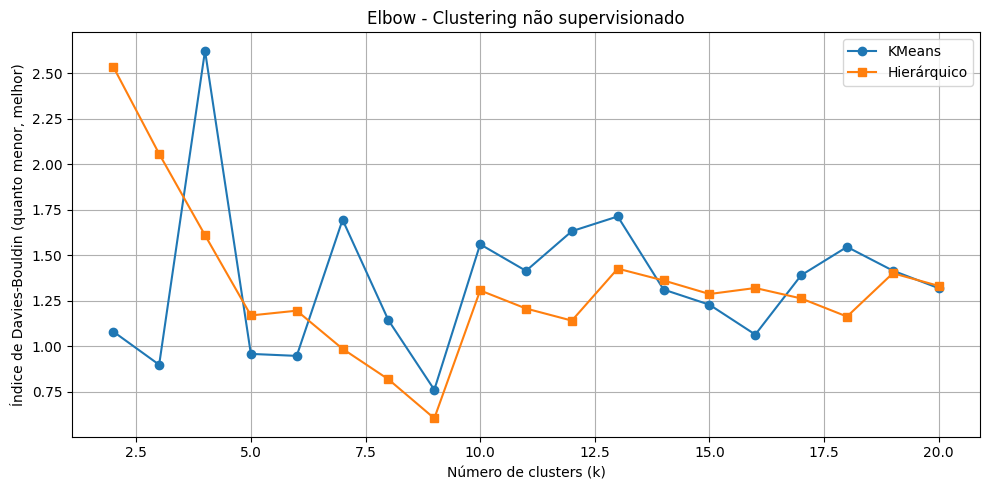

Melhor k (KMeans): 9
Melhor k (Hierárquico): 9
IRA KMeans: -0.0002
IRA Hierárquico: -0.0002


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler

# Seus dados já prontos
X = X_flat  # imagens já achatadas
y_true = y_balanced  # classe original (para IRA)

# Normalização (boa prática para clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ks = range(2, 21)

# KMeans (com 5 execuções para cada k)
db_kmeans = []
labels_kmeans_dict = {}

for k in ks:
    db_scores = []
    all_labels = []
    for seed in range(5):
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        db_scores.append(davies_bouldin_score(X_scaled, labels))
        all_labels.append(labels)
    db_kmeans.append(np.mean(db_scores))
    labels_kmeans_dict[k] = all_labels[np.argmin(db_scores)]  # salva melhor execução para IRA

# Hierárquico (linkage = ward, pode mudar)
db_hier = []
labels_hier_dict = {}

for k in ks:
    hier = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hier.fit_predict(X_scaled)
    db_hier.append(davies_bouldin_score(X_scaled, labels))
    labels_hier_dict[k] = labels

# Plot DB Index (Elbow)
plt.figure(figsize=(10, 5))
plt.plot(ks, db_kmeans, marker='o', label='KMeans')
plt.plot(ks, db_hier, marker='s', label='Hierárquico')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Índice de Davies-Bouldin (quanto menor, melhor)')
plt.title('Elbow - Clustering não supervisionado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Melhor k
melhor_k_kmeans = ks[np.argmin(db_kmeans)]
melhor_k_hier = ks[np.argmin(db_hier)]

print(f"Melhor k (KMeans): {melhor_k_kmeans}")
print(f"Melhor k (Hierárquico): {melhor_k_hier}")

# Índice CR (IRA)
ira_kmeans = adjusted_rand_score(y_true, labels_kmeans_dict[melhor_k_kmeans])
ira_hier = adjusted_rand_score(y_true, labels_hier_dict[melhor_k_hier])

print(f"IRA KMeans: {ira_kmeans:.4f}")
print(f"IRA Hierárquico: {ira_hier:.4f}")


In [13]:
from sklearn.metrics import silhouette_score

silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans_dict[melhor_k_kmeans])
silhouette_hier = silhouette_score(X_scaled, labels_hier_dict[melhor_k_hier])

print(f"Silhouette KMeans: {silhouette_kmeans:.4f}")
print(f"Silhouette Hierárquico: {silhouette_hier:.4f}")

Silhouette KMeans: 0.9187
Silhouette Hierárquico: 0.9277


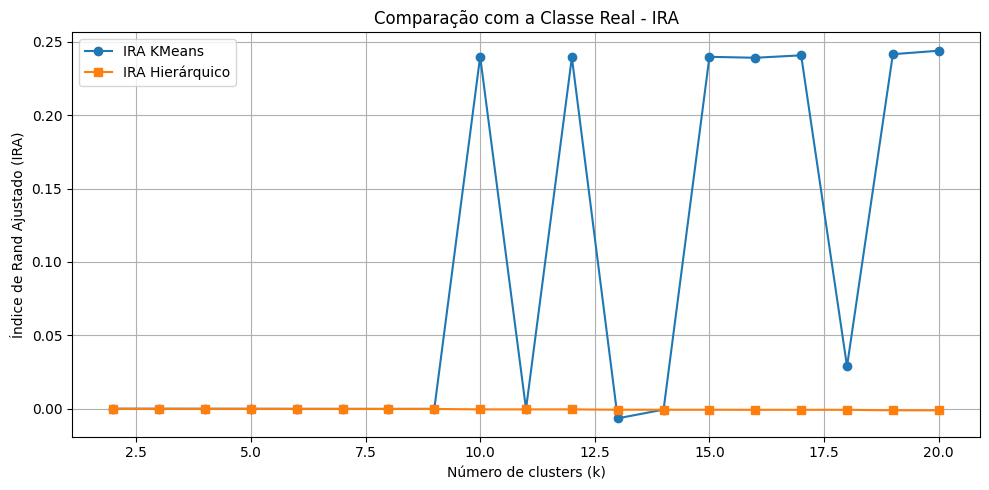

In [14]:
ira_kmeans_list = [adjusted_rand_score(y_true, labels_kmeans_dict[k]) for k in ks]
ira_hier_list = [adjusted_rand_score(y_true, labels_hier_dict[k]) for k in ks]

plt.figure(figsize=(10, 5))
plt.plot(ks, ira_kmeans_list, marker='o', label='IRA KMeans')
plt.plot(ks, ira_hier_list, marker='s', label='IRA Hierárquico')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Índice de Rand Ajustado (IRA)')
plt.title('Comparação com a Classe Real - IRA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Treinando uma KNN

In [15]:
# fazendo a divisão em treino, teste e validação
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Entrada para os modelos com Base Reduzida 3 (PCA)
X_balanced = np.array(BaseReduzida3)
y_balanced = np.array([list(color_to_class.values()).index(label) for label in patch_labels])

X_flat = X_balanced
# Valores de k a testar
k_values = [1, 3, 5, 7, 10]

In [16]:
# Para armazenar os resultados de acurácia da base original
accuracy_results_original = {
    "10-fold CV": {},
    "Hold-out 90/10": {},
    "Hold-out 80/20": {},
    "Hold-out 70/30": {}
}

# --- 1. 10-fold cross-validation ---
print("Executando 10-fold CV com base original...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    acc_scores = cross_val_score(knn, X_flat, y_balanced, cv=cv, scoring='accuracy')
    accuracy_results_original["10-fold CV"][k] = acc_scores.mean()
    print(f"k={k} | Acurácia média: {acc_scores.mean():.4f}")

Executando 10-fold CV com base original...
k=1 | Acurácia média: 0.7169
k=3 | Acurácia média: 0.7536
k=5 | Acurácia média: 0.7739
k=7 | Acurácia média: 0.7834
k=10 | Acurácia média: 0.7888


In [17]:
# --- 2. Hold-out 90/10 ---
print("\nExecutando Hold-out 90/10...")
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_balanced, test_size=0.10, stratify=y_balanced, random_state=42)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_results_original["Hold-out 90/10"][k] = acc
    print(f"k={k} | Acurácia: {acc:.4f}")


Executando Hold-out 90/10...
k=1 | Acurácia: 0.7208
k=3 | Acurácia: 0.7582
k=5 | Acurácia: 0.7754
k=7 | Acurácia: 0.7769
k=10 | Acurácia: 0.7852


In [18]:
# --- 3. Hold-out 80/20 ---
print("\nExecutando Hold-out 80/20...")
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_balanced, test_size=0.20, stratify=y_balanced, random_state=42)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_results_original["Hold-out 80/20"][k] = acc
    print(f"k={k} | Acurácia: {acc:.4f}")


Executando Hold-out 80/20...
k=1 | Acurácia: 0.7129
k=3 | Acurácia: 0.7534
k=5 | Acurácia: 0.7706
k=7 | Acurácia: 0.7758
k=10 | Acurácia: 0.7859


In [19]:
# --- 4. Hold-out 70/30 ---
print("\nExecutando Hold-out 70/30...")
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_balanced, test_size=0.30, stratify=y_balanced, random_state=42)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_results_original["Hold-out 70/30"][k] = acc
    print(f"k={k} | Acurácia: {acc:.4f}")


Executando Hold-out 70/30...
k=1 | Acurácia: 0.7185
k=3 | Acurácia: 0.7584
k=5 | Acurácia: 0.7769
k=7 | Acurácia: 0.7796
k=10 | Acurácia: 0.7839


## Arvore de decisão

In [20]:
import os
os.environ["OPENBLAS_VERBOSE"] = "0"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Valores de max_depth a testar
depth_values = [3, 5, 7]

print("=== 1. Validação cruzada (10-fold CV) ===")
for depth in depth_values:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(model, X_flat, y_balanced, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))
    print(f"Acurácia média (max_depth={depth}): {scores.mean():.4f}")

=== 1. Validação cruzada (10-fold CV) ===
Acurácia média (max_depth=3): 0.7677
Acurácia média (max_depth=5): 0.7778
Acurácia média (max_depth=7): 0.7854


In [21]:
print("\n=== 2. Hold-out 90/10 ===")
for depth in depth_values:
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y_balanced, test_size=0.1, random_state=42, stratify=y_balanced)
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia (max_depth={depth}): {acc:.4f}")


=== 2. Hold-out 90/10 ===
Acurácia (max_depth=3): 0.7687
Acurácia (max_depth=5): 0.7784
Acurácia (max_depth=7): 0.7792


In [22]:
print("\n=== 3. Hold-out 80/20 ===")
for depth in depth_values:
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia (max_depth={depth}): {acc:.4f}")


=== 3. Hold-out 80/20 ===
Acurácia (max_depth=3): 0.7653
Acurácia (max_depth=5): 0.7725
Acurácia (max_depth=7): 0.7807


In [23]:
print("\n=== 4. Hold-out 70/30 ===")
for depth in depth_values:
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia (max_depth={depth}): {acc:.4f}")


=== 4. Hold-out 70/30 ===
Acurácia (max_depth=3): 0.7654
Acurácia (max_depth=5): 0.7769
Acurácia (max_depth=7): 0.7834


## Naive bayes

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Modelo com parâmetros fixos
model = GaussianNB(priors=None, var_smoothing=1e-9)

print("=== 1. Validação cruzada (10-fold CV) ===")
scores = cross_val_score(model, X_flat, y_balanced, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))
print(f"Acurácia média (GaussianNB): {scores.mean():.4f}")

=== 1. Validação cruzada (10-fold CV) ===
Acurácia média (GaussianNB): 0.6791


In [25]:
print("\n=== 2. Hold-out 90/10 ===")
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_balanced, test_size=0.1, random_state=42, stratify=y_balanced)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia (GaussianNB): {acc:.4f}")


=== 2. Hold-out 90/10 ===
Acurácia (GaussianNB): 0.6849


In [26]:
print("\n=== 3. Hold-out 80/20 ===")
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia (GaussianNB): {acc:.4f}")


=== 3. Hold-out 80/20 ===
Acurácia (GaussianNB): 0.6804


In [27]:
print("\n=== 4. Hold-out 70/30 ===")
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia (GaussianNB): {acc:.4f}")


=== 4. Hold-out 70/30 ===
Acurácia (GaussianNB): 0.6756
